In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the image
omni_image = cv2.imread("C:/Users/govin/Downloads/Omnidirectional_Training/Office_A/resized_Despacho_LM_X_120_Y_480.bmp")

In [3]:
# Define the ROI parameters
original_size =402
original_size2=402
outer_mask_radius = 200
inner_mask_radius = 50
center_x = original_size // 2
center_y = original_size2 // 2

# Create a binary mask for the ROI
mask = np.zeros_like(omni_image[:, :, 0])
rows, cols = np.indices(mask.shape)
distance = np.sqrt((rows - center_x)**2 + (cols - center_y)**2)
mask[(distance <= outer_mask_radius) & (distance >= inner_mask_radius)] = 1

# Apply the mask to extract the ROI
roi_image = cv2.bitwise_and(omni_image, omni_image, mask=mask)

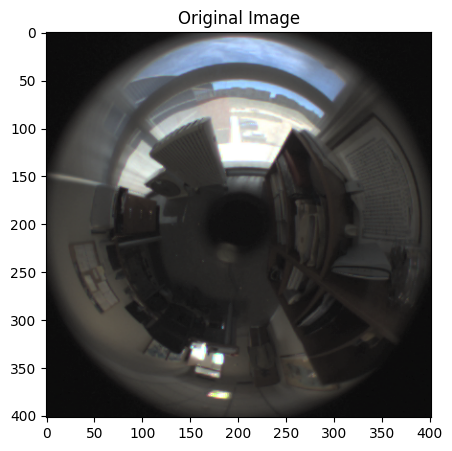

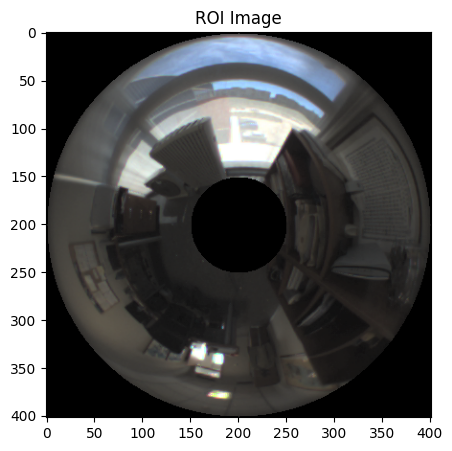

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cv2.cvtColor(omni_image, cv2.COLOR_BGR2RGB))
ax.set_title("Original Image")
plt.show()
    
# Display the ROI image with convex hulls
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
ax.set_title("ROI Image")
plt.show()
    

In [5]:
# Create an ORB object
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = orb.detectAndCompute(roi_image, None)

# Draw keypoints on the image
img_kp = cv2.drawKeypoints(roi_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT, color=(0, 0, 255))

In [17]:
len(keypoints)

479

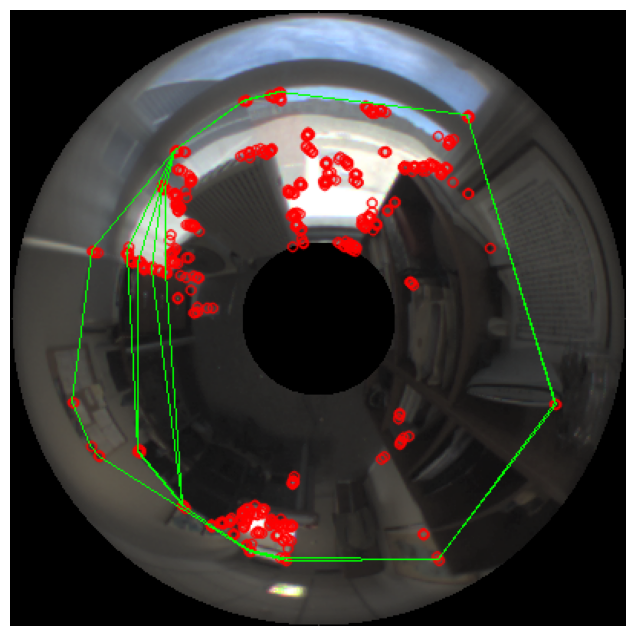

Number of Convex Hull Layers: 5


In [6]:
# Convert keypoints to points
points = np.array([kp.pt for kp in keypoints], dtype=np.float32)

# Sort points based on their x-coordinate
sorted_points = sorted(points, key=lambda x: x[0])

# Find the convex hull using Graham scan algorithm
def orientation(p, q, r):
    return (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])

def convex_hull(points):
    n = len(points)
    if n < 3:
        return []

    hull = []
    l = 0
    for i in range(1, n):
        if points[i][0] < points[l][0]:
            l = i

    p = l
    q = None
    while True:
        hull.append(points[p])
        q = (p + 1) % n
        for i in range(n):
            if orientation(points[p], points[i], points[q]) < 0:
                q = i
        p = q
        if p == l:
            break

    return hull

# Number of layers of convex hulls
num_layers = 5

# Iterate to find multiple layers of convex hulls
remaining_points = sorted_points
convex_hull_layers = []  # Store the convex hull layers
for layer in range(num_layers):
    # Find the convex hull of the remaining points
    convex_hull_points = convex_hull(remaining_points)

    # Break the loop if no more convex hulls can be found
    if len(convex_hull_points) < 3:
        break

    # Convert the convex hull points to an array
    convex_hull_points = np.array(convex_hull_points, dtype=np.int32)

    # Draw the convex hull on the image
    cv2.polylines(img_kp, [convex_hull_points], isClosed=True, color=(0, 255, 0), thickness=1)

    # Remove the points inside the convex hull from the remaining points
    remaining_points = [point for point in remaining_points if point not in convex_hull_points]
    
    # Remove 50 points from the remaining points
    remaining_points = remaining_points[10:]

    # Add the convex hull points to the convex hull layers
    convex_hull_layers.append(convex_hull_points)

# Display the image with keypoints and multiple layers of convex hulls with increased size
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Print the number of convex hull layers found
print("Number of Convex Hull Layers:", len(convex_hull_layers))


In [42]:
print(convex_hull_layers)

len(convex_hull_layers[0])

[array([[ 40, 255],
       [ 53, 156],
       [107,  91],
       [152,  59],
       [175,  53],
       [298,  68],
       [298,  69],
       [356, 257],
       [279, 358],
       [180, 359],
       [156, 353],
       [ 58, 291],
       [ 52, 284]]), array([[ 76, 158],
       [ 77, 154],
       [107,  91],
       [153,  58],
       [175,  53],
       [298,  68],
       [298,  69],
       [355, 256],
       [279, 358],
       [178, 357],
       [176, 357],
       [156, 352],
       [131, 336],
       [114, 324],
       [112, 323],
       [ 83, 288]]), array([[ 83, 286],
       [ 83, 164],
       [ 99, 114],
       [107,  91],
       [153,  58],
       [175,  53],
       [298,  68],
       [298,  69],
       [355, 256],
       [279, 358],
       [178, 357],
       [156, 352],
       [131, 336],
       [114, 324],
       [ 84, 288]]), array([[ 92, 169],
       [ 99, 115],
       [ 99, 114],
       [107,  91],
       [153,  58],
       [175,  53],
       [298,  68],
       [298,  69],
     

13

In [36]:

def hull_census_transform(descriptors, convex_hull):
    binary_code = []

    num_points = len(convex_hull)

    for i in range(num_points):
        current_point = convex_hull[i]
        next_point = convex_hull[(i + 1) % num_points]  # Wrap around to the first point for the last one

        current_idx = current_point[0]
        next_idx = next_point[0]

        current_desc = descriptors[current_idx]
        next_desc = descriptors[next_idx]

        if np.linalg.norm(current_desc) > np.linalg.norm(next_desc):
            binary_code.append(1)
        else:
            binary_code.append(0)

    return binary_code



# Initialize an empty list to store the binary codes
binary_codes = []

# Iterate over the convex hull layers
for layer in convex_hull_layers:
    # Compute the binary code for the layer using the Hull Census Transform
    layer_binary_code = hull_census_transform(descriptors, layer)

    # Append the binary code to the list of binary codes
    binary_codes.append(layer_binary_code)


# Display the binary codes
for i, binary_code in enumerate(binary_codes):
    print("Binary Code for Layer", i + 1, ":", binary_code)


Binary Code for Layer 1 : [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]
Binary Code for Layer 2 : [0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Binary Code for Layer 3 : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1]
Binary Code for Layer 4 : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]
Binary Code for Layer 5 : [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]


In [37]:
len(binary_codes[0])

13

In [39]:
binary_codes

[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
 [0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
 [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1],
 [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0],
 [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]]